In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
from performRPCA import rpca
from performFilter import performFilter
from perform_EOG_regression import perform_EOG_regression
from prep.prep_pipeline import prep_pipeline

class Preprocess:
    
    def __init__(self,eeg,params):
        eeg.load_data()
        self.eeg = eeg
        self.eog = None
        self.bad_chs = None
        self.params = params
        self.index = 0
        self.filtered = eeg.copy()
        self.eeg_filt_eog = None
        self.eeg_filt_eog_rpca = None
        self.pyautomagic = {'perform_prep' : False,\
                          'perform_filter' : False, \
                          'perform_eog_regression' : False, \
                          'perform_RPCA' : False}
        self.fig1 = None
        self.fig2 = None
        
        #Return noisy channels found using the prep_pipline()
    def perform_prep(self):
        self.pyautomagic['perform_prep'] = True
        chans = self.eeg.info['ch_names']
        self.bad_chs = chans[4:5]+chans[30:32]+[chans[50]]
        return self.bad_chs #prep_pipeline(self.eeg, self.params)
    
    #Filter data
    def perform_filter(self):
        self.pyautomagic['perform_filter'] = True
        return performFilter(self.filtered.get_data(), self.eeg.info['sfreq'],\
                                             self.params['filter_type'], \
                                             self.params['filt_freq'],\
                                             self.params['filter_length'])
    #remove artifact from EOG
    def perform_eog_regression(self):
        if ('eog' in self.filtered):
            eeg = self.filtered.copy()
            self.eog = self.filtered.copy()        
            if (self.params['eog_regression'] == True):
                self.pyautomagic['perform_eog_regression'] = True
            else:
                self.pyautomagic['perform_eog_regression'] = False
            eeg.pick_types(eeg=True)
            self.eog.pick_types(eog=True)
            self.filtered._data = perform_EOG_regression(eeg.get_data(),self.eog.get_data())
        return self.filtered
    
    #clean data using rpca
    def perform_RPCA(self):
        self.pyautomagic['perform_RPCA'] = True
        return rpca(self.eeg_filt_eog._data, \
                    self.params['lam'], \
                    self.params['tol'], \
                    self.params['max_iter'])
    
    #Return figures of the data
    def plot(self):
        self.fig1 = plt.figure(1,frameon=False)
        plt.setp(self.fig1,facecolor=[1,1,1], figwidth=15, figheight=50)
        ax = self.fig1.add_subplot(8, 1, 1)
        #EOG Graph
        if 'eog' in self.filtered:
            data = self.eog._data
            scale_min = np.min(np.min(data))
            scale_max = np.max(np.max(data))
            data = data - ((scale_max + scale_min)/2)
            plt.imshow(data,aspect='auto',extent=[0,(data.shape[1]/self.eeg.info['sfreq']),self.eog.info['nchan'],0],cmap=plt.get_cmap('coolwarm'))
            plt.title('Filtered EOG data')
            plt.colorbar()
        else:
            plt.title('No EOG data available')
            self.params['eog_regression'] = False

        #EEG Filtered Plot
        ax = self.fig1.add_subplot(8, 1, 2)
        data = self.filtered._data
        scale_min = np.min(np.min(data))
        scale_max = np.max(np.max(data))
        data = data - ((scale_max + scale_min)/2)
        plt.imshow(data,aspect='auto',extent=[0,(data.shape[1]/self.eeg.info['sfreq']),self.eeg.info['nchan'],0],cmap=plt.get_cmap('coolwarm'))
        #plt.clim(scale_min,scale_max)
        plt.colorbar()
        plt.title('Filtered EEG data')

        #EEG Filtered Plot Without Bad Channels
        allchan = raw.info['ch_names']
        ax = self.fig1.add_subplot(8, 1, 3)
        #delete this next line (index) when performPrep is fully functional
        self.index = np.array([4,12,18,19,20,21,30,31,32,41,42,44,45,46,47])

        data = self.filtered._data
        scale_min = np.min(np.min(data))
        scale_max = np.max(np.max(data))

        for i in range(len(self.index)): #len(badChannels)
            #index[i] = allchan.index(badChannels[i])
            data[(self.index[i]-1),:] = scale_min * np.ones((self.eeg._data.shape[1]))
        data = data - ((scale_max + scale_min)/2)
        plt.imshow(data,aspect='auto',extent=[0,(data.shape[1]/self.eeg.info['sfreq']),self.eeg.info['nchan'],0],cmap=plt.get_cmap('coolwarm'))
        #plt.clim(scale_min,scale_max)
        plt.title('Detected bad channels')
        plt.colorbar()



        # Plot with EOG regression
        ax = self.fig1.add_subplot(8, 1, 4)

        if self.params['eog_regression']:
            data = self.eog._data
            data = np.delete(data, (self.index-1),0)
            scale_min = np.min(np.min(data))
            scale_max = np.max(np.max(data))
            data = data - ((scale_max + scale_min)/2)
            plt.imshow(data,aspect='auto',extent=[0,(data.shape[1]/self.eeg.info['sfreq']),self.eeg.info['nchan'],0],cmap=plt.get_cmap('coolwarm'))
            #plt.clim(scale_min,scale_max)
            plt.colorbar()
            plt.title('EOG regressed out')
        else:
            plt.title('No EOG-Regression requested')

        #RPCA Corrected Data Plot
        ax = self.fig1.add_subplot(8, 1, 5)
        data = self.eeg_filt_eog_rpca._data
        data = np.delete(data,(self.index-1),0)
        rows = data.shape[0]
        scale_min = np.min(np.min(data))
        scale_max = np.max(np.max(data))
        data = data - ((scale_max + scale_min)/2)
        plt.imshow(data,aspect='auto',extent=[0,(data.shape[1]/self.eeg.info['sfreq']),self.eeg.info['nchan'],0],cmap=plt.get_cmap('coolwarm'))
        #plt.clim(scale_min,scale_max)
        plt.colorbar()
        plt.title('RPCA Corrected EEG data')

        #RPCA Noisy Data Plot
        ax = self.fig1.add_subplot(8, 1, 6)
        noise = np.delete(self.noise, (self.index-1),0)
        scale_min = np.min(np.min(self.noise))
        scale_max = np.max(np.max(self.noise))
        self.noise = self.noise - ((scale_max + scale_min)/2)
        plt.imshow(self.noise,aspect='auto',extent=[0,(data.shape[1]/self.eeg.info['sfreq']),self.eeg.info['nchan'],0],cmap=plt.get_cmap('coolwarm'))
        #plt.clim(scale_min,scale_max)
        plt.colorbar()
        plt.title('Noise')

        eeg_clean = self.eeg_filt_eog_rpca.copy()

        self.fig2 = plt.figure(2)
        plt.setp(self.fig2,facecolor=[1,1,1], figwidth=15)
        data2 = eeg_clean._data
        data2 = np.delete(data2, (self.index-1),0)
        scale_min = np.min(np.min(data2))
        scale_max = np.max(np.max(data2))
        data2 = data2 - ((scale_max + scale_min)/2)
        plt.imshow(data2,aspect='auto',extent=[0,(data2.shape[1]/self.eeg.info['sfreq']),self.eeg.info['nchan'],0],cmap=plt.get_cmap('coolwarm'))
        #plt.clim(scale_min,scale_max)
        plt.colorbar()
        plt.title('Filtered EEG data') 



        return self.fig1,self.fig2
    
    def fit(self):
        #performPrep
        self.eeg.info['bads'] = self.perform_prep()
        self.index = np.zeros(len(self.eeg.info['bads'])).astype(int) 

        #perfom filter
        self.filtered._data = self.perform_filter()
        
        #eog_regression
        self.eeg_filt_eog = self.filtered.copy()
        self.eeg_filt_eog = self.perform_eog_regression()

        #perform RPCA
        self.eeg_filt_eog_rpca = self.eeg_filt_eog.copy()
        self.eeg_filt_eog_rpca._data, self.noise = self.perform_RPCA()
    
        self.fig1, self.fig2 = self.plot()
        
        return self.eeg_filt_eog_rpca, self.fig1, self.fig2
    

Extracting EDF parameters from /Users/raphaelbechtold/Documents/MATLAB/Automagic/automagic/data/Subj1/S020R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...


Setting up high-pass filter at 0.5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Filter length: 1057 samples (6.606 sec)



/Users/raphaelbechtold/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:119: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


{'bad_chs': ['Fc2.', 'F5..', 'F3..', 'Pz..'],
 'eeg': <RawEDF  |  S020R01.edf, n_channels x n_times : 64 x 9760 (61.0 sec), ~4.9 MB, data loaded>,
 'eeg_filt_eog': <RawEDF  |  S020R01.edf, n_channels x n_times : 64 x 9760 (61.0 sec), ~4.7 MB, data loaded>,
 'eeg_filt_eog_rpca': <RawEDF  |  S020R01.edf, n_channels x n_times : 64 x 9760 (61.0 sec), ~4.7 MB, data loaded>,
 'eog': <RawEDF  |  S020R01.edf, n_channels x n_times : 2 x 9760 (61.0 sec), ~161 kB, data loaded>,
 'fig1': <Figure size 1080x3600 with 12 Axes>,
 'fig2': <Figure size 1080x288 with 2 Axes>,
 'filtered': <RawEDF  |  S020R01.edf, n_channels x n_times : 64 x 9760 (61.0 sec), ~4.7 MB, data loaded>,
 'index': array([ 4, 12, 18, 19, 20, 21, 30, 31, 32, 41, 42, 44, 45, 46, 47]),
 'noise': array([[-5.75431357e-05, -5.70270418e-05, -4.54232532e-05, ...,
        -5.75429152e-05, -5.75431357e-05, -5.75431357e-05],
       [-5.75431357e-05, -5.81653736e-05, -5.24078275e-05, ...,
        -5.75640815e-05, -5.75558874e-05, -5.75431357

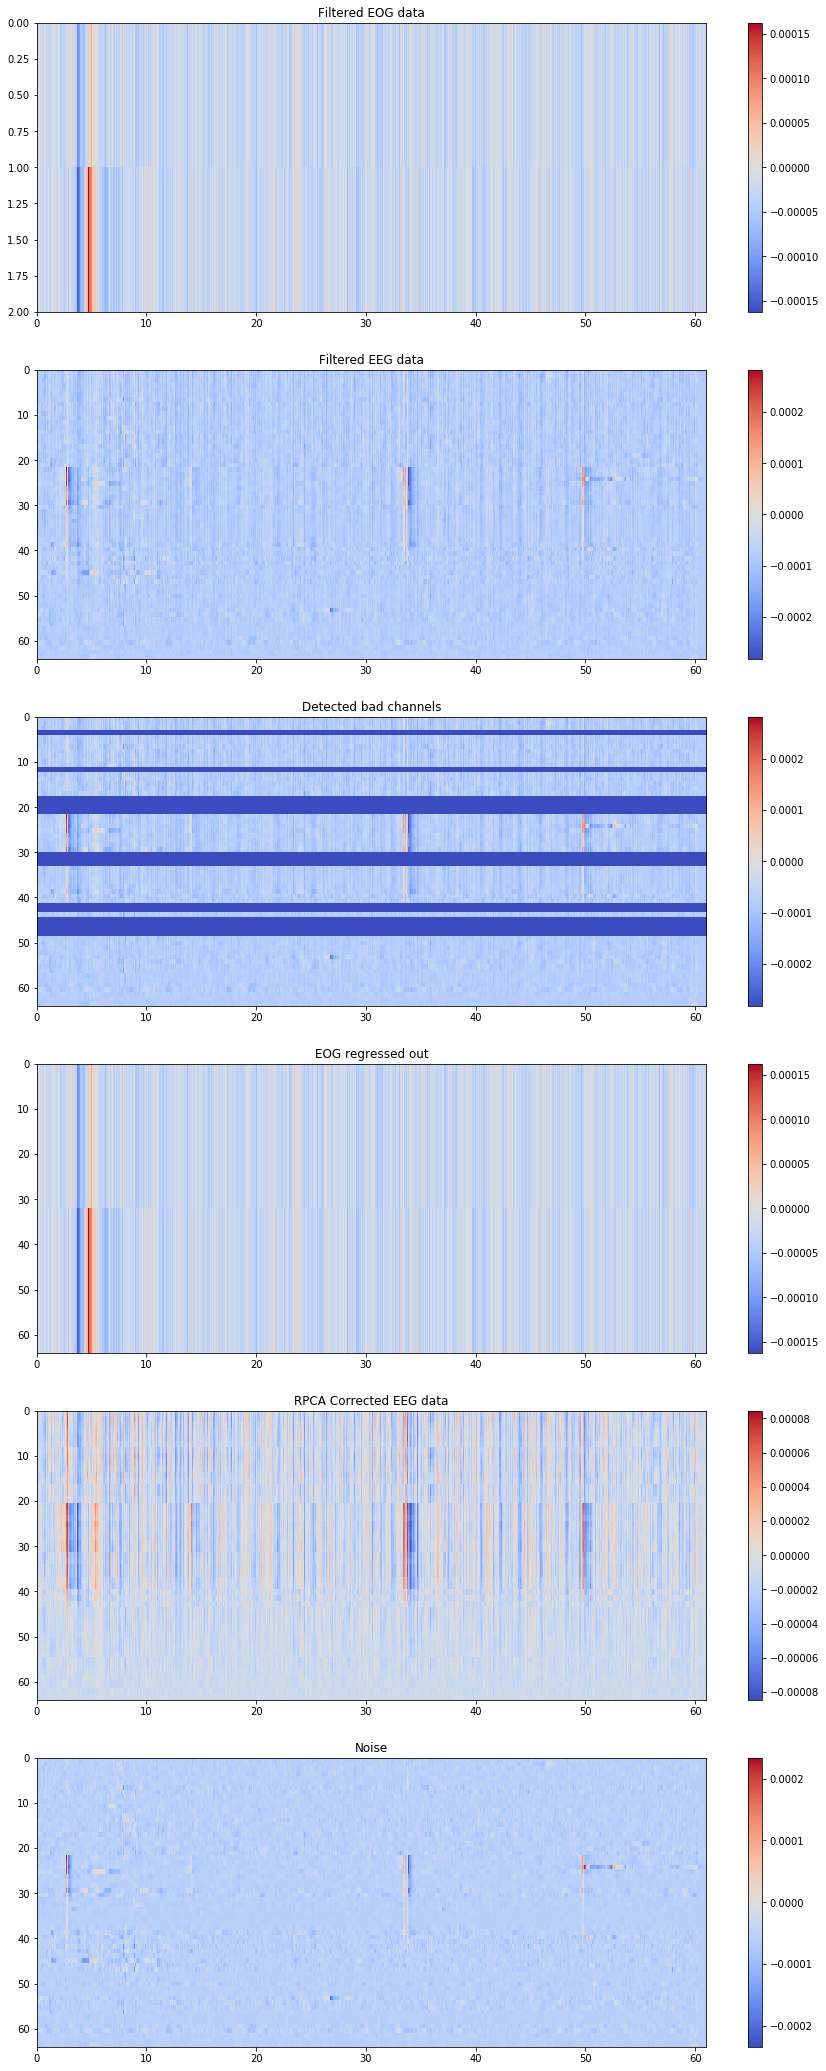

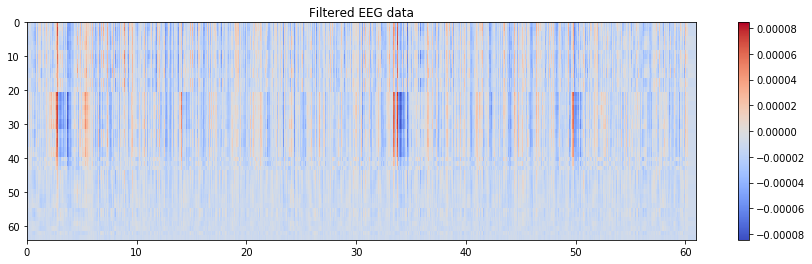

In [2]:
import pprint as pp
raw = mne.io.read_raw_edf('/Users/raphaelbechtold/Documents/MATLAB/Automagic/automagic/data/Subj1/S020R01.edf')
raw.info = mne.create_info(raw.info['ch_names'], 160, ['eeg']*62+['eog']*2)
params = {'line_noise' : 50,\
          'filter_type' : 'high', \
          'filt_freq' : None, \
          'filter_length' : 'auto', \
          'eog_regression' : True, \
          'lam' : -1, \
          'tol' : 1e-7, \
          'max_iter': 1000 \
          }
preprocess = Preprocess(raw,params)
raw, fig1, fig2 = preprocess.fit()

In [227]:
import pytest 

raw = mne.io.read_raw_edf('/Users/raphaelbechtold/Documents/MATLAB/Automagic/automagic/data/Subj1/S020R01.edf')
raw.info = mne.create_info(raw.info['ch_names'], 160, ['eeg']*62+['eog']*2)
params = {'line_noise' : 50,\
          'filter_type' : 'high', \
          'filt_freq' : None, \
          'filter_length' : 'auto', \
          'eog_regression' : True, \
          'lam' : -1, \
          'tol' : 1e-7, \
          'max_iter': 1000 \
          }
preprocess = Preprocess(raw,params)

def test_performEOGRegression():
    eeg=np.array([[1, 2, 4, 0.8], [0.1, 0.2, 0.4, 0.9]])
    eog=np.array([[9, 10, 11, 12], [10, 12, 3, 4]])
    raw.info = mne.create_info(raw.info['ch_names'], 160, ['eeg']*62+['eog']*2)
    params = {'line_noise' : 50,\
              'filter_type' : 'high', \
              'filt_freq' : None, \
              'filter_length' : 'auto', \
              'eog_regression' : True, \
              'lam' : -1, \
              'tol' : 1e-7, \
              'max_iter': 1000 \
              }
    preprocess = Preprocess(raw,params)
    assert np.array_equal(np.round(performEOGRegression(eeg, eog, {"PerformEOGRegression": "Yes"}), 2), np.round(np.array([[-0.42197603, 0.47275097, 1.71501431, -1.64957357], [-0.07695577, 0.04392939, -0.2369535, 0.23831638]]),2))

def test_basic_input():
    # Generate 20s dummy EEG data(sampling freq 1kHz)
    # composed of low freq sinusoid signal(10Hz), high freq sinusoid signal(80Hz), power freq sinusoid signal(60Hz),
    times = np.arange(0, 20, .001)
    sfreq = 1000
    low_freq_signal = 5*np.sin(2*np.pi*10*times)
    high_freq_signal = np.cos(2*np.pi*80*times)
    power_freq_noise = 2*np.sin(2*np.pi*60*times)
    input_signal = low_freq_signal + high_freq_signal + power_freq_noise

    output_lowpass_filt = performFilter.performFilter(input_signal, sfreq, 'low', 30)
    output_highpass_filt = performFilter.performFilter(input_signal, sfreq, 'high', 50)
    output_notch_filt = performFilter.performFilter(input_signal, sfreq, 'notch', 60)

    # Test 30Hz low pass filter, the output should only include 10Hz sinusoid signal
    lowpass_error = output_lowpass_filt - low_freq_signal
    assert (np.sqrt(np.mean(lowpass_error**2)) < 0.1)
    # Test 50Hz high pass filter, the output should only include 60Hz and 80Hz sinusoid signal
    highpass_error = output_highpass_filt - (high_freq_signal + power_freq_noise)
    assert (np.sqrt(np.mean(highpass_error**2)) < 0.1)
    # Test 60Hz notch filter, the output should only include 10Hz and 80Hz sinusoid signal
    notch_error = output_notch_filt - (high_freq_signal + low_freq_signal)
    assert (np.sqrt(np.mean(notch_error**2)) < 0.1)


def test_no_input():
    with pytest.raises(TypeError):
        performFilter.performFilter()


def test_lack_filter_input():
    """
    If filter_type is not specified, no filtering will be done, the output should be exactly the same with the input

    """
    times = np.arange(0, 20, .001)
    sfreq = 1000
    input_signal = np.random.normal(0.5, size=np.size(times))
    assert np.array_equal(performFilter.performFilter(input_signal, sfreq), input_signal)    
def test_basic_input1():
    EEG = np.array([[1,2],[3,4]])
    expected_A = np.array([[1.00000014,1.47051825],[1.47569674,2.17003868]])
    expected_E = np.array([[0.,0.52948166],[1.52430317,1.82996138]])
    A,E = rpca(EEG);
    assert(np.allclose(A,expected_A))
    assert(np.allclose(E,expected_E))
    print('test_basic_input1 Pass')

def test_basic_input2():
    EEG = np.array([[1,2,3],[4,5,6],[7,8,9]])
    expected_A = np.array([[1.5999989,1.99999912,2.3999982],\
                           [3.99999961,5.00000076,5.99999904],\
                           [5.13368148,6.41710344,7.70052173]])
    expected_E = np.array([[-5.99998725e-01,4.82951146e-07,6.00002018e-01],\
                           [0.00000000e+00,-0.00000000e+00,5.78509154e-07],\
                           [1.86631877e+00,1.58289609e+00,1.29947849e+00]])

    A,E = rpca(EEG);
    assert(np.allclose(A,expected_A))
    assert(np.allclose(E,expected_E))
    print('test_basic_input2 Pass')

def test_basic_input3():
    EEG = np.array([[1,2,3,4,5,6,7],[10,2,-30,6,15,39,92]])
    expected_A = np.array([[1.00000298,1.83282343,-0.27067405,4.00000311,4.00997941,4.01023028,4.01036702],\
                            [1.09121835,2.0000046,-0.29536361,4.36486378,4.37575008,4.37602383,4.37617304]])
    expected_E = np.array([[0,0.16717156,3.27067409,0,0.99002007,1.9897692,2.98963246],\
                            [8.90877893,0,-29.70463642,1.63513338,10.62425039,34.62397664,87.62382742]])
    A,E = rpca(EEG)
    assert(np.allclose(A,expected_A))
    assert(np.allclose(E,expected_E))
    print('test_basic_input3 Pass')

def test_no_input():
    with pytest.raises(TypeError):
        A,E = rpca()
    assert(True)
    print('test_no_input Pass')

def test_incorrect_input():
    with pytest.raises(AttributeError):
        A,E = rpca("Wrong input Type")
    assert(True)
    print('test_incorrect_input Pass')

def test_params1():
    EEG = np.array([[1,2,3],[4,5,6],[7,8,9]])
    lam = .7
    tol = 1e-8
    maxIter = 20
    expected_A = np.array([[1.21416342,1.99964425,2.79453087],\
                           [3.99964063,5.00068211,5.94182001],\
                           [6.75789278,7.94410702,9.00016552]])
    expected_E = np.array([[-0.21397595,0.,0.20564244],\
                           [0.,0.,0.05784774],\
                           [ 0.24228631,0.05555309,0.]])

    A,E = rpca(EEG,lam,tol,maxIter)
    assert(np.allclose(A,expected_A))
    assert(np.allclose(E,expected_E))
    print('test_params1 Pass')


def test_params2():
    EEG = np.array([[1,2,3],[4,5,6],[7,8,9]])
    lam = .2
    tol = 1e-3
    maxIter = 100
    expected_A = np.array([[0,0,0],[0,0,0],[0,0,0]])
    expected_E = np.array([[1,2,3],[4,5,6],[7,8,9]])
    A,E = rpca(EEG,lam,tol,maxIter)
    assert(np.allclose(A,expected_A))
    assert(np.allclose(E,expected_E))
    print('test_params2 Pass')


def test_params3():
    EEG = np.array([[1,2,3],[4,5,6],[7,8,9]])
    lam = .5
    tol = 1e-10
    maxIter = 1000
    expected_A = np.array([[1.45445617,2,2.14299791],\
                           [3.30885118,4.54994966,4.8752663],\
                           [3.31508751,4.55852514,4.88445492]])
    expected_E = np.array([[-0.45445617,0,0.85700209],\
                           [0.69114882,0.45005034,1.1247337],\
                           [3.68491249,3.44147486,4.11554508]])
    A,E = rpca(EEG,lam,tol,maxIter)
    assert(np.allclose(A,expected_A))
    assert(np.allclose(E,expected_E))
    print('test_params3 Pass')
    
def test_sample_input_correctType():
    raw = mne.io.read_raw_edf('./tests/test_data/S001R01.edf')

    params = {'line_noise' : 50, \
              'filter_type' : 'high', \
              'filt_freq' : None, \
              'filter_length' : 'auto', \
              'eog_index' : -1, \
              'lam' : -1,
              'tol' : 1e-7,
              'max_iter': 1000
             }


    eeg,fig1,fig2 = preprocess(raw, params)
    assert(type(eeg) == mne.io.edf.edf.RawEDF)
    assert(type(fig1) == type(plt.figure()))
    assert(type(fig2) == type(plt.figure()))


#Test each output type on a sample data set 2
def test_sample_input2_correctType():
    raw = mne.io.read_raw_edf('./tests/test_data/S001R04.edf')

    params = {'line_noise' : 50, \
              'filter_type' : 'high', \
              'filt_freq' : None, \
              'filter_length' : 'auto', \
              'eog_index' : -1, \
              'lam' : -1,
              'tol' : 1e-7,
              'max_iter': 1000
             }


    eeg,fig1,fig2 = preprocess(raw, params)
    assert(type(eeg) == mne.io.edf.edf.RawEDF)
    assert(type(fig1) == type(plt.figure()))
    assert(type(fig2) == type(plt.figure()))


Extracting EDF parameters from /Users/raphaelbechtold/Documents/MATLAB/Automagic/automagic/data/Subj1/S020R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
